<a href="https://colab.research.google.com/github/AlbertoDiGirolamo/ProgettoDataIntensive/blob/main/Progetto_Data_intensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

# Descrizione problema

Il dataset è composto da delle misurazioni biomediche dei sintomi di persone con il Parkinson.
Lo scopo principale dei dati è quello di prevedere il punteggio totale UPDRS (acronimo di Unified Parkinson’s Disease Rating Scale - scala di valutazione unificata per la malattia di Parkinson) composta da quattro parti consequenziali che esplorano l’aspetto mentale, l’umore, le attività della vita quotidiana, l’attività motoria prendendo in considerazione i vari segmenti corporei interessati e infine le eventuali complicazioni motorie.

# Data exploration

In [2]:
df = pd.read_csv('parkinsons_updrs.data')
#https://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring
display(df.head())

print('The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


The Datset consists of 22 features & 5875 samples.


Le colonne nella tabella contengono il numero del soggetto, l'età del soggetto, il sesso del soggetto, l'intervallo di tempo dalla data di reclutamento di riferimento, l'UPDRS motorio, l'UPDRS totale e 16 misure vocali biomediche.

Di seguito vengono elencate le feature presenti:
*   `subject#`: Numero intero che identifica in modo univoco ciascuna età
*   `age`: età del soggetto
*   `sex`: sesso del soggetto: "0" se è maschio, "1" se è femmina
*   `test_time`: tempo trascorso dal reclutamento. La parte intera è il numero di giorni di trascorsi dall'assunzione
*   `motor_UPDRS`: punteggio motorio del paziente affetto da parkinson
*   `total_UPDRS`: Punteggio UPDRS totale
*   `Jitter(%), Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP` : Diverse misure del livello di stato di estremo nervosismo o tremore nervoso
*   `Shimmer,Shimmer (dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA` : Una misurazione quantificata che descrive i cambiamenti temporali della vibrazione delle corde vocaliù
*   `NHR,HNR` : Due misure del rapporto tra rumore e componenti tonali nella voce
*   `RPDE` - Una misura di complessità dinamica non lineare
*   `DFA` : Esponente di ridimensionamento frattale del segnale
*   `PPE` : Una misura non lineare della variazione di frequenza fondamentale

## Analisi esplorativa dei dati:

Di seguito vengono mostrate le specifiche informazioni delle features seguite da il numero di righe uniche.




In [3]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


Come si osserva dalla descrizione del dataset, si rilevano la **media**, il valore **massimo** e **minimo**, la **deviazione standard** e i **percentili** di ogni features.

La variabile target `total_UPDRS` ha valori compresi nel range tra 7 e 55 punti.

In [4]:
df.nunique().sort_values()

sex                 2
age                23
subject#           42
Jitter:PPQ5       840
Shimmer(dB)       852
Jitter:RAP        853
motor_UPDRS      1080
total_UPDRS      1129
Jitter(%)        1305
Jitter:DDP       1703
test_time        2442
Shimmer:APQ3     2664
Shimmer:APQ5     2850
Shimmer:APQ11    3283
Shimmer          3581
Jitter(Abs)      4105
Shimmer:DDA      4223
PPE              4777
HNR              4780
DFA              5282
RPDE             5430
NHR              5532
dtype: int64

## Rimozione valori nulli

Procediamo ora a verificare se nel dataframe sono presenti valori nulli.

In [5]:
df.isna().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

Il dataset non contiene valori nulli, non è necessario quindi gestirli.

## Correlazione tra le feature

Di seguito viene riportata la matrice di correlazione per visualizzare le dipendenze che legano fra di loro le features.

In [6]:
def plot_correlation(dataset):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(dataset, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5});

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


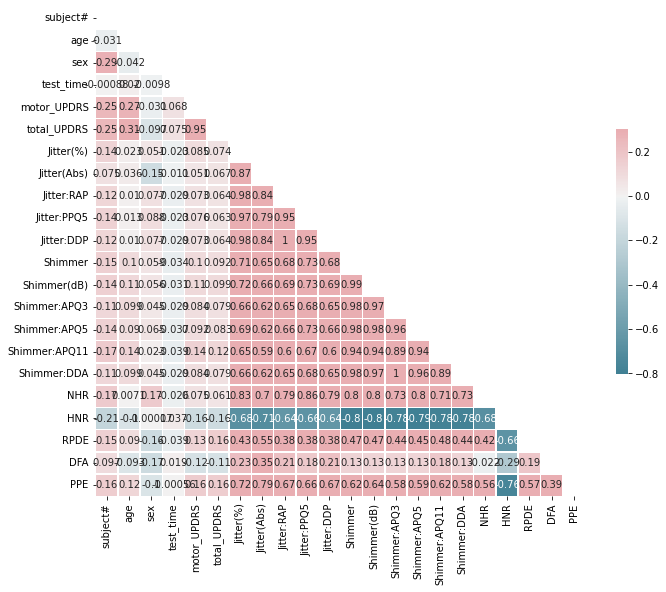

In [7]:
plot_correlation(df.corr())

Si può notare che sono presenti più feature che riguardano lo stesso dato e che quindi hanno una forte **correlazione diretta**.


*   Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP

*   Shimmer, Shimmer(dB), Shimmer:APQ3, ShimmerAPQ5, Shimmer:APQ11, Shimmer:DDA




Possiamo notare anche che la feature **HNR** (utilizzata per quantificare la qualità del segnale) possiede una forte correlazione inversa circa le feature **Jitter** e **Shimmer** (usate per valutare rispettivamente la stabilità del segnale e l'ampiezza).


Il dataset contiene quasi 6000 istanze, quindi per illustrare i grafici in modo chiaro è necessario prelevare un campione casuale di 1000 istanze.

In [8]:
sample = df.sample(n=1000, random_state=1)

Riproducendo la matrice di correlazione possiamo osservare alcune coppie di feature particolari, poichè legate da un rapporto di correlazione diretta, inversa e nulla:


*   Jitter:RAP - Jitter:DDP 
*   Shimmer - HNR
*   test_time - subject#




Text(0.5, 0, 'test_time')

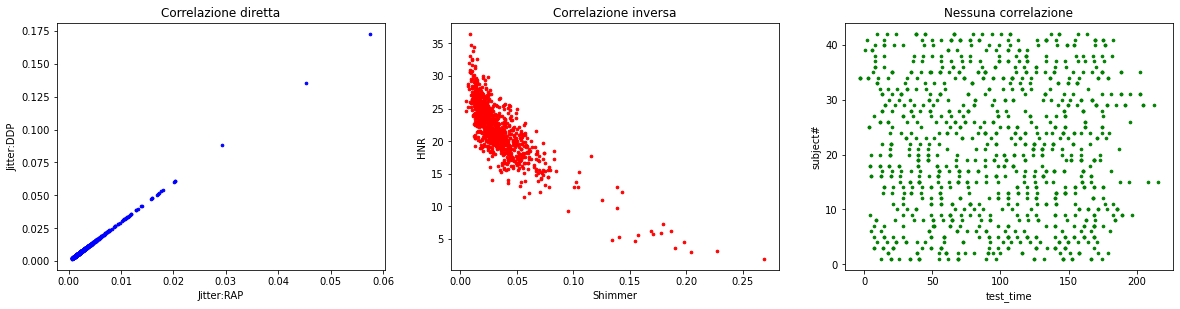

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.title("Correlazione diretta")
plt.scatter(sample['Jitter:RAP'], sample['Jitter:DDP'], s=7, c ='blue')
plt.ylabel('Jitter:DDP')
plt.xlabel('Jitter:RAP')

plt.subplot(2,3,2)
plt.title("Correlazione inversa")
plt.scatter(sample['Shimmer'], sample['HNR'], s=7, c ='red')
plt.ylabel('HNR')
plt.xlabel('Shimmer')

plt.subplot(2,3,3)
plt.title("Nessuna correlazione")
plt.scatter(sample['test_time'], sample['subject#'], s=7, c ='green')
plt.ylabel('subject#')
plt.xlabel('test_time')

Con i grafici a dispersione sopra mostrati è chiaro che alcune variabili presentano delle correlazioni influenzandosi reciprocamente.
*    **Correlazione diretta**: quando la variazione di un elemento interessa direttamente anche l'altro. 
*    **Correlazione inversa**: se alla variazione di un elemento corrisponde la variazione in senso contrario, quella dell'altro. 
*    **Nessuna correlazione**: le variazioni degli elementi non si influenzano tra loro.

Text(0.5, 0, 'age')

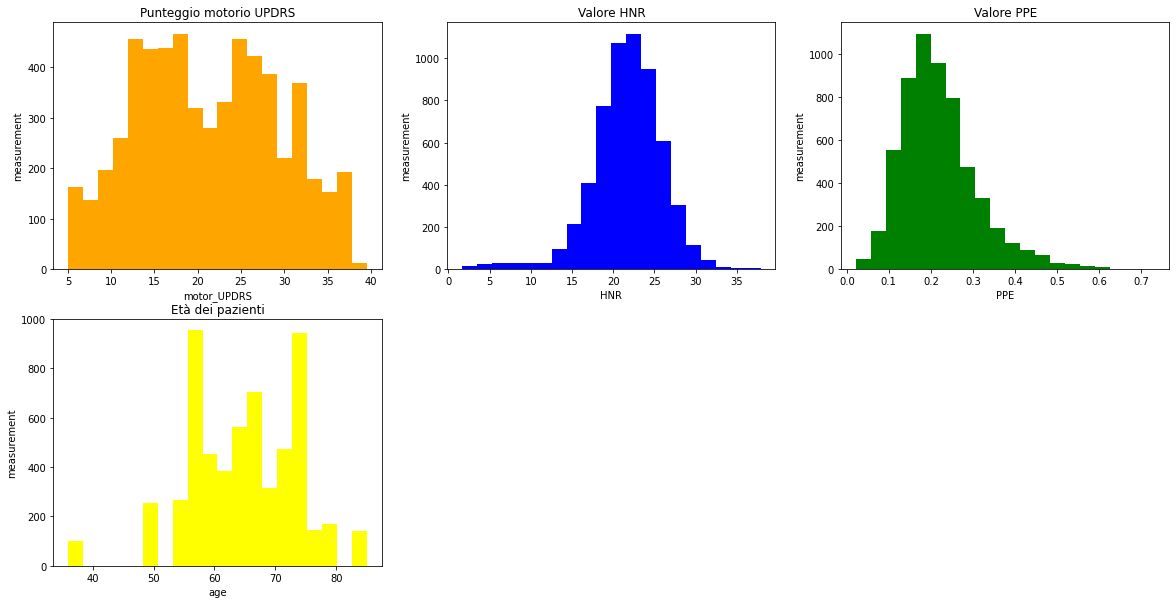

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.title('Punteggio motorio UPDRS')
plt.hist(df['motor_UPDRS'], bins=20,color='orange')
plt.ylabel('measurement')
plt.xlabel('motor_UPDRS')

plt.subplot(2,3,2)
plt.title('Valore HNR')
plt.hist(df['HNR'], bins=20,color='blue')
plt.ylabel('measurement')
plt.xlabel('HNR')

plt.subplot(2,3,3)
plt.title('Valore PPE')
plt.hist(df['PPE'], bins=20,color='green')
plt.ylabel('measurement')
plt.xlabel('PPE') 

plt.subplot(2,3,4)
plt.title('Età dei pazienti')
plt.hist(df['age'], bins=20,color='yellow')
plt.ylabel('measurement')
plt.xlabel('age')



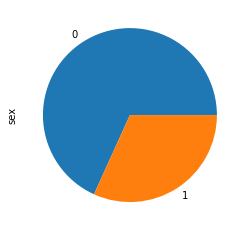

In [11]:
df['sex'].value_counts().plot.pie()

Il grafico a torta permette di visualizzare la rilevante maggioranza di soggetti maschi (indicizzati con 0) rispetto ai soggetti femmina (indicizzati con 1).

{'boxes': [<matplotlib.lines.Line2D at 0x7f8f87398bd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8f8739ec10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8f873a6c50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8f873a6710>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8f8739e190>,
  <matplotlib.lines.Line2D at 0x7f8f8739e6d0>]}

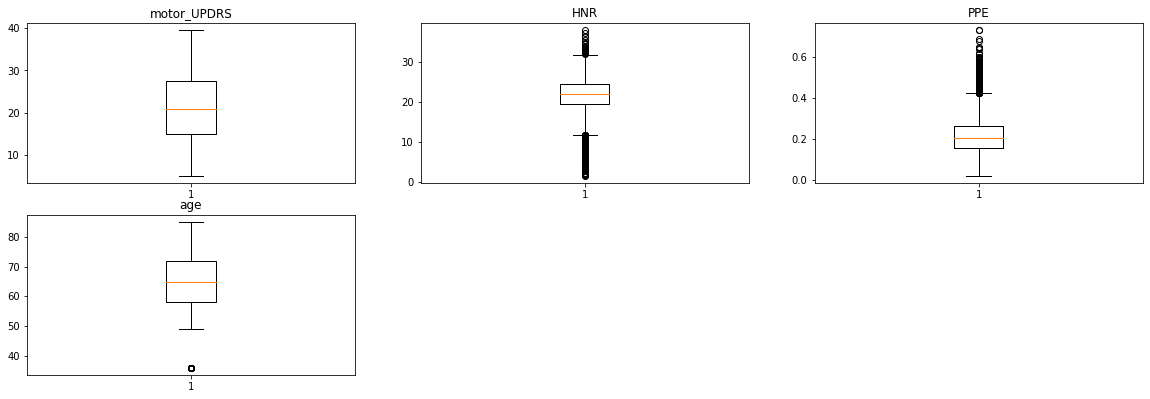

In [12]:
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
plt.title("motor_UPDRS")
plt.boxplot(df["motor_UPDRS"])

plt.subplot(3,3,2)
plt.title("HNR")
plt.boxplot(df["HNR"])

plt.subplot(3,3,3)
plt.title("PPE")
plt.boxplot(df["PPE"])

plt.subplot(3,3,4)
plt.title("age")
plt.boxplot(df["age"])

Possiamo notare grazie agli istogrammi e ai box plot che il dataset fornisce feature con dati omogenei.
Analizzando i valori possiamo vedere che esistono sia feature con una buona distribuzione e  feature che posseggono invece la maggior parte dei loro valori all'interno di un range.

# Normalizzazione e standardizzazione

In questa fase verranno valutati alcuni semplici modelli di regressione per determinare l'efficacia della standardizzazione delle feature e dell'individuazione di quelle meno rilevanti.
Succeccivamente si proverà a eliminare alcune feature per rendere più efficienti i modelli.

In [13]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [14]:
def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

La funzione `relative_error()` è utilizzata per determinare l'errore relativo.

La funzione `print_eval()` è usata per stampare le valutazioni sul modello passato come parametro.




## Definizione di training set e validation set

Procedendo è necessario suddividere il training set e il validation set per poter addestrare un semplice modello di regressione polinomiale

Si definisce come X l'insieme delle feature note, mentre come y la feature da predire.

In [15]:
y = df["total_UPDRS"]
X = df.drop(columns="total_UPDRS")

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [17]:
model = Pipeline([
    ("lr", LinearRegression())
])

%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: user 9.45 ms, sys: 4.28 ms, total: 13.7 ms
Wall time: 30.9 ms
   Mean squared error: 10.213
       Relative error: 9.11877%
R-squared coefficient: 0.90896


Addestrando un semplice modello di regressione lineare otteniamo già valori elevati.

## Standardizzazione

Essendo in scale diverse è necessario standardizzare e scalare il range di valori utilizzando `StandardScaler()`, altrimenti risulta difficile analizzare i valori restituiti.

In [18]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])

%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)


CPU times: user 12.9 ms, sys: 11.6 ms, total: 24.5 ms
Wall time: 17.4 ms
   Mean squared error: 10.213
       Relative error: 9.11877%
R-squared coefficient: 0.90896


In [19]:
pd.Series(model.named_steps["lr"].coef_, X.columns)

subject#          0.525675
age               0.603439
sex              -0.827943
test_time         0.161323
motor_UPDRS       9.909692
Jitter(%)        -1.297934
Jitter(Abs)       0.496708
Jitter:RAP       18.715336
Jitter:PPQ5      -0.144825
Jitter:DDP      -17.511176
Shimmer          -0.499906
Shimmer(dB)      -0.201256
Shimmer:APQ3     81.520228
Shimmer:APQ5      1.776065
Shimmer:APQ11    -1.119389
Shimmer:DDA     -81.783518
NHR              -0.145697
HNR              -0.310825
RPDE              0.242930
DFA              -0.195237
PPE              -0.328878
dtype: float64

Osservando la tabella possiamo vedere quali coefficenti sono positivi e quali sono negativi, possiamo dedurre quali fattori facciano aumentare il valore della variabile target e quali lo facciano calare.



## Individuazione delle feature meno rilevanti utilizzando Lasso

Vorremmo addestrare un modello meno complesso, dove alcuni parametri hanno valori nulli, ingorando le variabili meno rilevanti.

La regressione lasso consiste nella regressione lineare con regolarizzazione L1. Attraverso il parametro `alpha` è possibile indicare il peso della regolarizzazione.

In [20]:

modelLasso = Pipeline([
    ("scale", StandardScaler()),
    ("lasso", Lasso(alpha=0.05))
])

%time modelLasso.fit(X_train, y_train)
print_eval(X_val, y_val, modelLasso)


CPU times: user 12.9 ms, sys: 34.1 ms, total: 47 ms
Wall time: 27.9 ms
   Mean squared error: 10.451
       Relative error: 9.11041%
R-squared coefficient: 0.90684


In [21]:
pd.Series(modelLasso.named_steps["lasso"].coef_, X.columns)

subject#         0.394205
age              0.513251
sex             -0.745810
test_time        0.099772
motor_UPDRS      9.879856
Jitter(%)       -0.000000
Jitter(Abs)      0.154953
Jitter:RAP       0.000000
Jitter:PPQ5     -0.000000
Jitter:DDP       0.000000
Shimmer          0.000000
Shimmer(dB)      0.000000
Shimmer:APQ3     0.025912
Shimmer:APQ5     0.000000
Shimmer:APQ11   -0.347171
Shimmer:DDA      0.000000
NHR              0.000000
HNR             -0.161806
RPDE             0.186915
DFA             -0.111026
PPE             -0.195355
dtype: float64

Possiamo notare che come previsto è presente una diminuzione, seppur minima, di **R-squared**.
Molte feature rimosse avevano un forte correlazione tra di loro (Jitter(%), Jitter:RAP, Jitter:PPQ5, Jitter:DDP, Shimmer, Shimmer(dB), Shimmer:APQ5, Shimmer:DDA, NHR)


Procediamo ora ad addestrare un modello più complesso, usando feature non lineari per abbassare **MSE**.
Anche in questo caso verrà scelto l'iperparametro in modo arbitrario.

In [22]:
simpleModelScaled = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("std",  StandardScaler()),
    ("lr", LinearRegression())
])

%time simpleModelScaled.fit(X_train, y_train)
print_eval(X_val, y_val, simpleModelScaled)


CPU times: user 162 ms, sys: 87.6 ms, total: 250 ms
Wall time: 139 ms
   Mean squared error: 6.3986
       Relative error: 7.73840%
R-squared coefficient: 0.94296


Utilizzando le feature polinomiali **MSE** viene ridotto a discapito del tempo di elaborazione.
La dimensione del dataset utilizzato non accentua questo particolare, ma mostrando in output il tempo necessario si nota che è quasi 7 volte superiore.

Si procede ora ad eliminare le variabili azzerate dalla Lasso per verificare di quanto viene modificata l'accuratezza.

In [23]:
df = df.drop(columns=["Jitter(%)","Jitter:RAP","Jitter:PPQ5", "Jitter:DDP", "Shimmer", "Shimmer(dB)","Shimmer:APQ5",
                      "Shimmer:DDA", "NHR"])

In [24]:
y = df["total_UPDRS"]
X = df.drop(columns="total_UPDRS")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [25]:
simpleModelScaled = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("std",  StandardScaler()),
    ("lr", LinearRegression())
])

%time simpleModelScaled.fit(X_train, y_train)
print_eval(X_val, y_val, simpleModelScaled)



CPU times: user 55.7 ms, sys: 44 ms, total: 99.7 ms
Wall time: 59.3 ms
   Mean squared error: 6.1597
       Relative error: 7.81724%
R-squared coefficient: 0.94509


L'accuratezza è addiruttura di poco superiore e cosa importante il modello richiede solo 13 feature invece di 22

# Addestramento modelli di regressione

In quest sezione ci occuperemo di addestrare vari modelli di regressione e di valutare quale tra quelli utilizzati risulta più accurato.

Nella fase precedente abbiamo ottenuto i seguenti valori:


**Regressione Lineare**:
*   Mean squared error: 10.451
*   Relative error: 9.11041%
*   R-squared coefficient: 0.90684

**Regressione non Lineare**:
*   Mean squared error: 6.3986
*   Relative error: 7.73840%
*   R-squared coefficient: 0.94296

Notiamo un abbassamento dell'indice **MSE** di quasi il 40%, un abbassamento dell'**errore relativo** di di 1,4% e un aumento di **R-squared** di 0.04.

Possiamo non considerare quindi i modelli di regressione lineare e occuparci dei modelli che contengono feature polinomiali.

## Regressione Polinomiale, Ridge, e Kernel Ridge

Sui modelli utilizzati finora abbiamo impostato manualmente i valori di diversi iperparametri.
L'accuratezza del modello dipende da questi valori quindi verrà ora applicata la Grid Search determinandone i migliori.

Il metodo `k-fold` è utilizzato per valutare l'accuratezza di un modello poichè i dati sono suddivisi casualmente in k fold, ciascun gruppo è validato su un modello addestrato su tutti gli altri gruppi.

In [26]:
Kf = KFold(5, shuffle=True, random_state=42)

In [27]:
polyModel = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("regr", LinearRegression())
])
polyGrid = {
    "poly__degree": [2, 3],  
    
}
gs = GridSearchCV(polyModel, polyGrid, cv=Kf)
%time gs.fit(X_train, y_train)

print_eval(X_val, y_val, gs)
print('Best param:' +str(gs.best_params_))


CPU times: user 2.31 s, sys: 1.62 s, total: 3.93 s
Wall time: 2.07 s
   Mean squared error: 4.7929
       Relative error: 5.21042%
R-squared coefficient: 0.95728
Best param:{'poly__degree': 3}


Al termine della **GridSearch** su un modello non lineare viene determinato come ottimale l'iperparametro 3 per il grado del polinomio.

Con la funzione `print_eval` vengono mostrati i coefficenti di errore

Applichiamo successivamente la regressione **ridge** che utilizza la regolarizzazione **L2** cercando di ridurre i gradi del polinomio e verifichiamo se questo porta dei vantaggi.

In [28]:
modelRidge = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("regr", Ridge())
])
ridgeGrid = {
    "poly__degree": [2, 3],  
    "regr__alpha": [0.1,1,10]
}
gs = GridSearchCV(modelRidge, ridgeGrid, cv=Kf)
%time gs.fit(X_train, y_train)

print_eval(X_val, y_val, gs)
print('Best param:' +str(gs.best_params_))



CPU times: user 2.78 s, sys: 2.42 s, total: 5.2 s
Wall time: 2.71 s
   Mean squared error: 3.9511
       Relative error: 5.36865%
R-squared coefficient: 0.96478
Best param:{'poly__degree': 3, 'regr__alpha': 0.1}


La **Grid-Search** ha restituito come peso della regolarizzazione 0.1 e come grado del polinomio 3.
Possiamo notare che i coefficenti **R-squared** e **Mean squared error** sono leggermente migliori.

In [29]:
modelKernel = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
kernelGrid = {
    "regr__degree": range(2, 4),
    "regr__alpha": [0.1, 1, 10],
}
gs = GridSearchCV(modelKernel, kernelGrid, cv=Kf)
%time gs.fit(X_train, y_train)

print_eval(X_val, y_val, gs)
print('Best param:' +str(gs.best_params_))


CPU times: user 48.6 s, sys: 9.72 s, total: 58.3 s
Wall time: 38.5 s
   Mean squared error: 4.2368
       Relative error: 5.15999%
R-squared coefficient: 0.96223
Best param:{'regr__alpha': 0.1, 'regr__degree': 3}


Quest'ultimo modello possiede dei risultati simili al precedente ma con tempi di esecuzione maggiori. Non porta quindi alcun beneficio in questo problema.

#Alberi di regressione

##LightGBM

Il primo albero di regressione che studiamo è il  **Light Gradient Boosted Machine**. Il suo vantaggio è quello di utilizzare variazioni dell'algoritmo di addestramento rendendolo più efficente

In [30]:
from lightgbm import LGBMRegressor

In [31]:
lgbm = LGBMRegressor()
%time lgbm.fit(X_train, y_train)

CPU times: user 479 ms, sys: 39.5 ms, total: 519 ms
Wall time: 289 ms


LGBMRegressor()

In [32]:
print_eval(X_val, y_val, lgbm)

   Mean squared error: 0.16718
       Relative error: 1.06637%
R-squared coefficient: 0.99851


## XGBoost

Il secondo albero di regressione che esaminiamo ora è **XGBoost** che fornisce un'impementazione dell'algoritmo **Xtreme Gradient Boosting**

In [33]:
from xgboost import XGBRegressor

In [34]:
xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200, verbose_eval=True)
%time xgbm.fit(X_train, y_train)

CPU times: user 645 ms, sys: 12.8 ms, total: 658 ms
Wall time: 749 ms


XGBRegressor(n_estimators=200, objective='reg:squarederror', reg_alpha=0.0,
             reg_lambda=1.0, verbose_eval=True)

In [35]:
print_eval(X_val, y_val, xgbm)

   Mean squared error: 0.83591
       Relative error: 2.90189%
R-squared coefficient: 0.99255


## CatBoost

CatBoost è un algoritmo per aumentare il gradiente sugli alberi decisionali.

In [36]:
%pip install catboost
import catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [37]:
catbm = CatBoostRegressor(n_estimators=1000)
%time catbm.fit(X_train, y_train)

Learning rate set to 0.050798
0:	learn: 10.2931581	total: 50.8ms	remaining: 50.7s
1:	learn: 9.8757348	total: 54.2ms	remaining: 27s
2:	learn: 9.4621314	total: 57.3ms	remaining: 19s
3:	learn: 9.0616361	total: 60.5ms	remaining: 15.1s
4:	learn: 8.6987942	total: 64ms	remaining: 12.7s
5:	learn: 8.3355490	total: 67.4ms	remaining: 11.2s
6:	learn: 7.9862914	total: 71ms	remaining: 10.1s
7:	learn: 7.6627741	total: 74.5ms	remaining: 9.23s
8:	learn: 7.3761709	total: 78.5ms	remaining: 8.64s
9:	learn: 7.0844863	total: 82.7ms	remaining: 8.18s
10:	learn: 6.8125217	total: 86.3ms	remaining: 7.76s
11:	learn: 6.5635464	total: 89.8ms	remaining: 7.4s
12:	learn: 6.3170837	total: 93.5ms	remaining: 7.1s
13:	learn: 6.0836053	total: 97.3ms	remaining: 6.86s
14:	learn: 5.8726832	total: 101ms	remaining: 6.64s
15:	learn: 5.6602881	total: 105ms	remaining: 6.45s
16:	learn: 5.4704276	total: 108ms	remaining: 6.27s
17:	learn: 5.2845847	total: 112ms	remaining: 6.12s
18:	learn: 5.1068740	total: 116ms	remaining: 5.99s
19:	le

In [38]:
print_eval(X_val, y_val, catbm)

   Mean squared error: 0.1107
       Relative error: 0.99708%
R-squared coefficient: 0.99901


**CatBoost** ottiene i risultati migliori:
*   **MSE**: 0.11
*   **Errore relativo**: 1%
*   **R-squared**: 0.99

# Valutazione dei modelli di regressione

## Nested Cross-Fold Validation

Viene implementata una funzione per effettuare la Nested Cross-Fold Validation sui modelli addestrati in precedenza.

In [39]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        score = gs.score(X_val, y_val)
        results.append(score)
    return results

Per la validazione si utilizzano 3 fold esterni e 5 interni

In [40]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)

In [41]:
print(nested_cv(polyModel, polyGrid))

[0.9572832215476657, 0.9676737436031069, 0.9714140319209424]


In [42]:
print(nested_cv(modelRidge, ridgeGrid))

[0.964778656113633, 0.9662088451447846, 0.9691245564395394]


In [43]:
print(nested_cv(modelKernel, kernelGrid))

[0.9709803069466866, 0.9676547793654389, 0.9732646312788062]


Possiamo notare che la Nested Cross Fold Validation applicata al modello Kernel Ridge ha tempi di elaborazione elevati rispetto agli altri modelli, ottiene però i risultati migliori.


# Conclusioni

Durante lo studio di questo dominio applicativo siamo riusciti a ottenere un'ottima precisione.
I dati utilizzati li abbiamo interpretati ed esplorati, abbiamo rimosso le inesattezze e imprecisioni (come eventuali valori nulli) ed eseguito vari modelli di regressione cercando di ottenere gli iperparametri migliori.
Tramite opportune rilevazioni, come **Mean squared error**, **Relative error**, **R-squared coefficient** e il tempo di esecuzione, siamo riusciti a determinati i modelli più adatti a questo problema.


Di seguito viene riportata la classifica dei migliori modelli:

1.   CatBoost
2.   Light BGM
3.   Kernel Ridge



In [44]:
pd.Series(catbm.feature_importances_, X.columns)

subject#         10.638716
age               8.005586
sex               4.916259
test_time         2.022878
motor_UPDRS      69.368994
Jitter(Abs)       1.085824
Shimmer:APQ3      0.335133
Shimmer:APQ11     0.340310
HNR               0.235846
RPDE              0.561882
DFA               2.290114
PPE               0.198459
dtype: float64

In conclusione visualizzando i pesi dei coefficenti determinati da Catboost possiamo visualizzare che la variabile che influenza maggiormente il punteggio totale UPDRS è la variabile che rappresenta il punteggio motorio del paziente nella scala UPDRS.
Notiamo anche che ad influenzare la variabile target è l'età del paziente.

I risultati finali sono praticamente perfetti. Questo ci porta a pensare che probabilemente le features presenti nel dataset rappresentano i parametri principali che clinicamente vengono controllati in un paziente affetto da Parkinson.
